In [19]:
from numba import njit
from scipy.linalg import expm, sqrtm
import numpy as np
import copy
import scienceplots
from pathlib import Path 
import pandas as pd
import time
from scipy import interpolate
from dataclasses import dataclass
import pickle
# import RTS 
from tqdm import tqdm
# from src import RTS as RTS
import RTS as RTS
import matplotlib.pyplot as plt
plt.style.use(['science', 'grid', 'no-latex'])
# plt.style.use(['science', 'grid'])
import Direct_Strapdown as ds

params = {'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large','xtick.labelsize':'large', 
          'ytick.labelsize':'large', 'legend.fontsize': 'x-large','mathtext.fontset':'stix', 'font.family':'STIXGeneral'}
plt.rcParams.update(params)

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")


def SOW2HOD(SOW): 
    """ 
    Procedure to convert Seconds Of Week (SOW) to Hour Of Day (HOD) 
    --------------------------------------------------------------
    
    Input: 
        SOW:    array [N x 1]

    Output: 
        HOD:   array [N x 1] 

    ---------------------------------------------------------------
    Author: Christian Solgaard (DTU - Master student) 09/11-2023
    """
    remainder = (SOW/3600)[0]  % 24
    relative_h = SOW/3600 - (SOW/3600)[0]
    HOD = remainder + relative_h                # HOD -> Hour of Day 
    return HOD

def HOD2SOD(HOD): 
    """ 
    Procedure to convert Hour Of Day (HOD) to Secound Of Day (SOD) 
    --------------------------------------------------------------
    
    Input: 
        HOD:    array [N x 1]

    Output: 
        SOD:   array [N x 1] 

    ---------------------------------------------------------------
    Author: Christian Solgaard (DTU - Master student) 12/12-2023
    """
    SOD = HOD*60*60
    return SOD

def SOW2SOD(SOW): 
    """ 
    Procedure to convert Seconds Of Week (SOW) to Seconds Of Day (SOD) 
    --------------------------------------------------------------
    
    Input: 
        SOW:    array [N x 1]

    Output: 
        SOD:   array [N x 1] 

    ---------------------------------------------------------------
    Author: Christian Solgaard (DTU - Master student) 12/12-2023
    """
    HOD = SOW2HOD(SOW)
    SOD = HOD2SOD(HOD)
    return SOD


@njit
def approximate_expm(A, order):
    """
    Approximate the matrix exponential of A using a Taylor series expansion.
    
    Parameters:
    A (array-like): Input matrix.
    order (int): Order of the Taylor series expansion (higher order for more accuracy).
    
    Returns:
    expm_A (numpy.ndarray): Approximation of the matrix exponential.

    -------------------------------------------------------------------------
    Author: Christian Solgaard (DTU) 
    """
    expm_A = np.eye(A.shape[0])  # Initialize with the identity matrix
    A_power = np.eye(A.shape[0])  # Initialize with the identity matrix

    for i in range(1, order):
        A_power = np.dot(A_power, A) / i
        expm_A += A_power

    return expm_A

@njit
def valLoan(F, PSD, tau): 
    """
    Implementation of Van Loan method for forming transition matrix and
    system noise matrix from system matrix and power spectral density matrix
    
    -------------------------------------------------------------------------
    
    Input:
      F       NxN array representing system matrx
      PSD     NxN array representing matrix of power spectral densities
      tau     scalar representing propagation time interval [s]
    
    Output:
      Phi     NxN array representing transition matrix
      Q       NxN array representing system noise matrix
    
    -------------------------------------------------------------------------
    Author: Christian Solgaard (DTU), implemented on the work done by: 
    Tim Jensen (DTU) 21/05/2018
    """

    # Get dimension 
    nvar = len(F)

    # Form index values
    id1 = nvar
    id2 = nvar * 2

    # Derive Transition and System Noise Matrices
    # Form A matrix using Brown and Hwang (3.9.22)
    idx = F.shape

    # Derive Transition and System Noise Matrices
    # Form A matrix using Brown and Hwang (3.9.22)
    A = np.zeros((idx[0]*2,idx[0]*2))
    A[0:idx[0], 0:idx[0]] = -F * tau
    A[0:idx[0], idx[0]:] = PSD * np.abs(tau)
    A[idx[0]:, 0:idx[0]] = np.zeros((nvar, nvar))
    A[idx[0]:, idx[0]:] = F.T * tau

    # B = expm(A)
    B = approximate_expm(A, 20)    

    # The lower-right partition is the transpose of the transition matrix
    Phi = B[id1:id2, id1:id2].T

    # Compute Q using Brown and Hwang (3.9.25)
    # Q = Phi * B[0:nvar, id1:id2]
    Q = Phi @ B[0:nvar, id1:id2]
    
    return Phi, Q



def KalmanFilterLowpass(obs, varible, val):
    """
    Function to perform Kalman filtering for low-pass filtering a time series.

    Parameters:
    - obs: Dictionary containing time and gravity disturbance observations
    - varible: int - Determine which varible to lowpass, North, East or Down (0, 1 or 2)


    Returns:
    - kf: Kalman filter estimates
    - rts: Variables passed to the smoothing routine

    -------------------------------------------------------------------------
    Author: Christian Solgaard (DTU) 01/12-2023

    """
    # Number of state variables
    ns = 3
    ns2 = ns ** 2

    # Kalman Filter Estimates
    no_updates = len(obs['time'])
    kf = {'time': np.zeros(no_updates),
          'profile': np.zeros((no_updates, ns)),
          'profile_std': np.zeros((no_updates, ns))}

    # Allocate space for variables passed to smoothing routine
    rts = {'time': np.zeros(no_updates - 1),
           'profile': np.zeros((no_updates - 1, ns)),
           'x_posterior': np.zeros((no_updates - 1, ns)),
           'P_prior': np.zeros((no_updates - 1, ns2)),
           'P_posterior': np.zeros((no_updates - 1, ns2)),
           'Transition': np.zeros((no_updates - 1, ns2))}

    # Design Kalman Filter
    dg_obs_std = 100  # Standard deviation of measurement [mGal]
    dg_sigma = 100    # Gravity anomaly standard deviation [mGal]
    dg_beta = val   # Gravity anomaly correlation parameter [1/m] (orig = 1/5000)
    beta_d = 100 * dg_beta

    # Initialise Kalman Filter
    dg_ini = 0  # Initial estimate of gravity disturbance [mGal]
    dg_std = 100  # Standard deviation on gravity disturbance [mGal]

    dg = dg_ini
    dg1 = 0
    dg2 = 0

    x = np.zeros([3,1])
    P = np.diag([dg_std**2, 1e-4, 1e-4])

    kf['time'][0] = obs['time'][0]
    kf['profile'][0, :] = [dg, dg1, dg2]
    kf['profile_std'][0, :] = np.sqrt(np.diag(P))

    # Perform Kalman Filtering
    for n_epoch in range(1, no_updates):
        PSD = np.zeros((3, 3))
        PSD[2, 2] = (16 / 3) * (beta_d**5) * (dg_sigma**2)

        F = np.array([[0, 1, 0],
                      [0, 0, 1],
                      [-beta_d**3, -3 * beta_d**2, -3 * beta_d]])

        tau = obs['time'][n_epoch] - obs['time'][n_epoch - 1]
        Phi, Q = valLoan(F, PSD, tau)

        P = np.dot(np.dot(Phi, P), Phi.T) + Q

        rts['time'][n_epoch - 1] = obs['time'][n_epoch]
        rts['Transition'][n_epoch - 1, :] = Phi.flatten(order='F')
        rts['P_prior'][n_epoch - 1, :] = P.flatten(order='F')

        dg_obs = obs['dg'][n_epoch, varible]
        R = dg_obs_std**2
        H = np.array([[1, 0, 0]])
        dz = dg_obs - dg

        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R))
        # x = x + np.dot(K, dz)
        x = x + K * dz
        P = np.dot(np.dot(np.eye(3) - np.dot(K, H), P), (np.eye(3) - np.dot(K, H)).T) + np.dot(np.dot(K, R), K.T)

        rts['x_posterior'][n_epoch - 1, :] = x.flatten()
        rts['P_posterior'][n_epoch - 1, :] = P.flatten(order='F')

        dg = dg + x[0]
        dg1 = dg1 + x[1]
        dg2 = dg2 + x[2]
        x = np.zeros([3,1])

        kf['time'][n_epoch] = obs['time'][n_epoch]
        kf['profile'][n_epoch, :] = np.array([dg, dg1, dg2]).flatten()
        rts['profile'][n_epoch - 1, :] = kf['profile'][n_epoch, :]
        kf['profile_std'][n_epoch, :] = np.sqrt(np.diag(P))

    return kf, rts



def plot_ref_line(DS, rts_final):
    import pyproj
    from pyproj import Transformer
    survey = {}
    survey["dg"] = rts_final["profile"][:,0]
    survey["time"] = rts_final["time"]

    pipeline = "+ellps=GRS80 +proj=pipeline +step +proj=utm +zone=30"
    transform_object = Transformer.from_pipeline(pipeline)
    geodetic_corr = [DS["lon"], DS["lat"], DS["h"]]
    UTM_corr = transform_object.transform(*geodetic_corr)

    min = 9700
    max = 20200

    Ref = {}                                        # Determined using visual inspection
    Ref["all_lines"] = np.arange(min,max+1)
    Ref["Line_1"] = np.arange(min+350,min+1950+1)
    Ref["Line_2"] = np.arange(min+2250,min+4200+1)
    Ref["Line_3"] = np.arange(min+4490,min+6050+1)
    Ref["Line_4"] = np.arange(min+6400,min+8300+1)
    Ref["Line_5"] = np.arange(min+8650,max-250+1)

    # Calc distance to refererence point. 
    def dist2ref(x1, y1, refx2, refy2): 
        dist = np.sqrt((x1 - refx2)**2 + (y1 - refy2)**2)
        return dist

    ref_x = UTM_corr[0][[min+300]]
    ref_y = UTM_corr[1][[min+300]]

    @dataclass
    class Verification_line: 
        name: str
        index: np.array
        dist: np.array
        dg: np.array
        time: np.array
        # h: np.array
        # roll: np.array
        # pitch: np.array
        # yaw: np.array
    ref_line_dist = np.arange(10,140,.5)
    Line = ["Line_1", "Line_2", "Line_3", "Line_4", "Line_5"]
    RMS_line = {}
    RMS_line["dist"] = ref_line_dist
    for i in range(len(Line)): 
        dist_line = dist2ref(UTM_corr[0][Ref[Line[i]]], 
                            UTM_corr[1][Ref[Line[i]]], ref_x, ref_y)
        RMS_line[Line[i]] = ds.interpolate_DS(dist_line*1e-3, rts_final["profile"][Ref[Line[i]], 0]-50, ref_line_dist, "linear", "extrapolate")

        Line[i] = Verification_line(Line[i], Ref[Line[i]], 
                                    dist_line, rts_final["profile"][Ref[Line[i]], 0], 
                                    rts_final["time"][Ref[Line[i]]])
        
    RMS_line["combined"] = np.array([RMS_line["Line_1"], RMS_line["Line_2"], RMS_line["Line_3"], RMS_line["Line_4"], RMS_line["Line_5"]]).T
    RMS_line["mean_line"] = np.sum(RMS_line["combined"], axis=1)/len(RMS_line["combined"][0,:])

    # res_ref = np.array([RMS_line["Line_1"] - RMS_line["mean_line"], [RMS_line["Line_2"] - RMS_line["mean_line"], [RMS_line["Line_3"] - RMS_line["mean_line"], [RMS_line["Line_4"] - RMS_line["mean_line"], [RMS_line["Line_5"] - RMS_line["mean_line"] ])
    # Create an array with the differences
    res_ref = np.array([
        RMS_line["Line_1"] - RMS_line["mean_line"],
        RMS_line["Line_2"] - RMS_line["mean_line"],
        RMS_line["Line_3"] - RMS_line["mean_line"],
        RMS_line["Line_4"] - RMS_line["mean_line"],
        RMS_line["Line_5"] - RMS_line["mean_line"]
    ])

    # Concatenate along the second axis (axis=1) to get a single vector
    res_ref_concatenated = np.concatenate(res_ref)

    def rms(x): 
        rms_ = np.sum(x**2)/len(x)
        return rms_

    rms_ = rms(res_ref_concatenated)/np.sqrt(2)

    return np.round(rms_, 5)



In [ ]:
    # dg_obs_std = 205  # Standard deviation of measurement [mGal]
    # dg_sigma = val    # Gravity anomaly standard deviation [mGal]
    # dg_beta = 1/6100   # Gravity anomaly correlation parameter [1/m] (orig = 1/5000)

In [20]:
start = 1000
stop = 2000
step = 500
# val = np.arange(start, stop, step)
val = np.flip(1/np.arange(start, stop, step))
rms_val = np.zeros(val.shape)
file_path = "../Results/DS_300Hz_150s_3_stages.pkl"
for i in tqdm(range(len(val)), colour="green"): 

    print(f"Loading DS results from: {file_path}")
    with open(file_path, 'rb') as file: 
        DS = pickle.load(file)

    kf, rts = KalmanFilterLowpass(DS, int(2), val[i])
    rts_result = RTS.RTS_smoother(rts)

    rms_val[i] = plot_ref_line(DS, rts_result)

  0%|          | 0/2 [00:00<?, ?it/s]

Loading DS results from: ../Results/DS_300Hz_150s_3_stages.pkl
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   ]

 50%|█████     | 1/2 [00:05<00:05,  5.43s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.61 seconds
Loading DS results from: ../Results/DS_300Hz_150s_3_stages.pkl
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... ]

100%|██████████| 2/2 [00:09<00:00,  4.92s/it]

100%  [ .................... ] done
Time elapsed: 1.74 seconds


In [41]:
start = 10
stop = 400
step = 5
val = np.arange(start, stop, step)
len(val)

start = 1000
stop = 24000
step = 250
# val = np.arange(start, stop, step)
val = np.flip(1/np.arange(start, stop, step))
len(val)

92

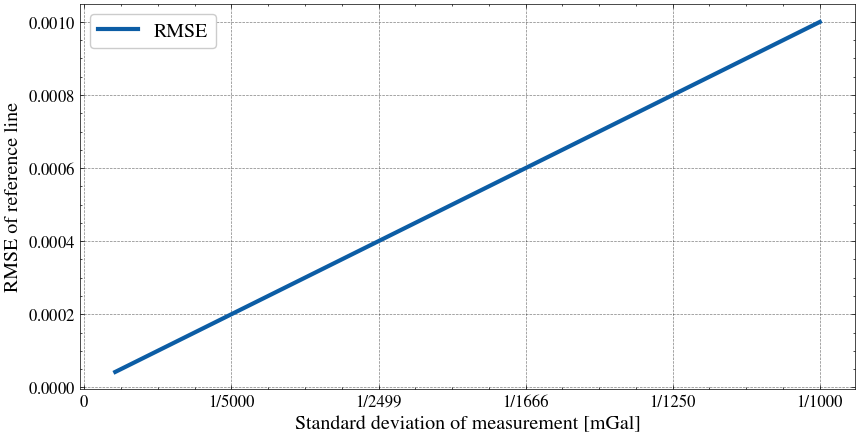

In [44]:
from matplotlib.ticker import FuncFormatter
start = 1000
stop = 24000
step = 250
# val = np.arange(start, stop, step)
val = np.flip(1/np.arange(start, stop, step))
len(val)
def format_func(value, tick_number):
    if value == 0:
        return "0"  # or any other custom formatting for zero
    else:
        return f"1/{int(1/value)}"

# Determine minimum: 
idx = (rms_val == min(rms_val))

plt.figure(figsize=(10,5))
plt.plot(val, val, lw=3, label="RMSE")
# plt.scatter(val[idx][0], rms_val[idx][0], s=100, label=f"Minimum RMSE value: {np.round(rms_val[idx][0], 2)} @ corr: 1/{int(1/val[idx][0])} [1/m]", color="red",zorder=10)
plt.xlabel("Standard deviation of measurement [mGal]")
plt.ylabel("RMSE of reference line")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

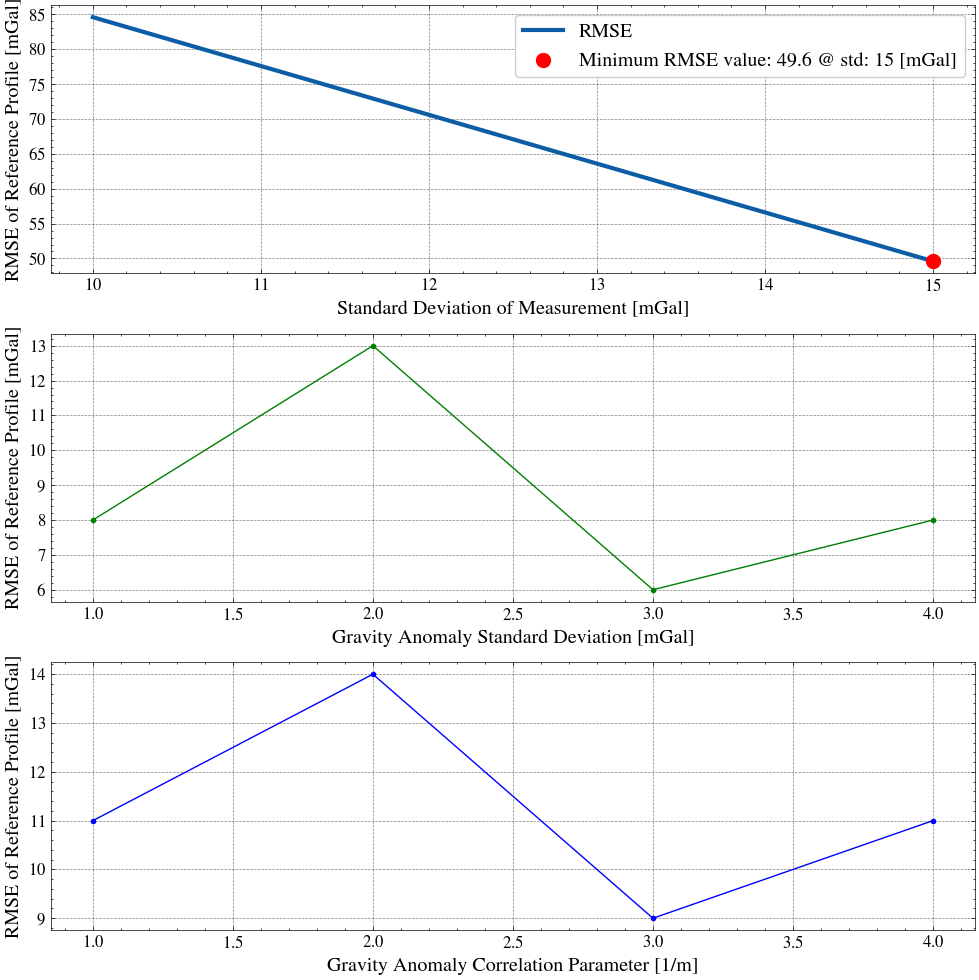

In [15]:
x = [1, 2, 3, 4]
y1 = [10, 15, 7, 10]
y2 = [8, 13, 6, 8]
y3 = [11, 14, 9, 11]

# Create a figure and three subplots arranged vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 10))  # Adjust figsize as needed

# Plot data on each subplot
axs[0].plot(val, rms_val, lw=3, label="RMSE")
axs[0].scatter(val[idx][0], rms_val[idx][0], s=100, label=f"Minimum RMSE value: {np.round(rms_val[idx][0], 2)} @ std: {val[idx][0]} [mGal]", color="red",zorder=10)
axs[0].set_xlabel("Standard Deviation of Measurement [mGal]")
axs[0].set_ylabel("RMSE of Reference Profile [mGal]")
axs[0].legend()

axs[1].plot(x, y2, 'g.-')
axs[1].set_xlabel("Gravity Anomaly Standard Deviation [mGal]")
axs[1].set_ylabel("RMSE of Reference Profile [mGal]")



axs[2].plot(x, y3, 'b.-')
axs[2].set_xlabel("Gravity Anomaly Correlation Parameter [1/m]")
axs[2].set_ylabel("RMSE of Reference Profile [mGal]")


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()